In [1]:
##This cell will be used for all required packages
import pandas as pd
import requests
import json
from pyjstat import pyjstat
import seaborn as sns
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 

#importing stats packages/modules
import scipy.stats as stats
from scipy.stats import binom,poisson,zscore,shapiro,norm,randint
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# Section 1 - loading in prepared datasets

In [3]:
#loading in Ireland air traffic data
ireland_airtraffic = pd.read_csv('ireland_airtraffic.csv')
ireland_airtraffic_agg = pd.read_csv('ireland_airtraffic_agg.csv')

#loading in norway air traffic passenger data
norway_passenger = pd.read_csv('norway_passenger.csv')
norway_pass_agg = pd.read_csv('norway_pass_agg.csv')

#loading in norway air freight data
norway_freight = pd.read_csv('norway_freight.csv')
norway_freight_agg = pd.read_csv('norway_freight_agg.csv')

#loading in finland air traffic passenger data
Finland_passenger = pd.read_csv('Finland_passenger.csv')

# Section 2 (Statistics Question 2):

## Inferential statistics on possible population values

While researching the proportion of passengers using each of the 5 main Irish airports it was stated in the following report that "Dublin Airport handles 80% of all international flights to Ireland."

Report: https://consult.fingal.ie/ga/consultation/draft-fingal-county-development-plan-2023-2029/chapter/chapter-8-dublin-airport


I want to see if there is a difference between the proportion of international flights handled by dublin airport (determined from my sample) compared to the proportion outlined in the study by "Fingal Development Plan". 

A two proportion z-test allows you to compare two proportions to see if they are the same.

The null hypothesis (H0) for the test is that the proportions are the same.
The alternate hypothesis (H1) is that the proportions are not the same.

**Hypothesis:**
- The null hypothesis (H0) for the test is that the proportions are the same.
- The alternate hypothesis (H1) is that the proportions are not the same.

## 2.1 calculating the proportions

In [6]:
#calculating the proportion of commercial_flights from each airport in Ireland
airport_proportions = ireland_airtraffic[ireland_airtraffic['region']!='Domestic']
airport_proportions = airport_proportions.groupby(['year','month','airport'])['commercial_flights'].sum().reset_index()

#getting the total number of flights across all airports each month
tot_per_month = airport_proportions.groupby(['year','month'])['commercial_flights'].sum().reset_index()

#merging the total to the original dataset
airport_proportions = airport_proportions.merge(tot_per_month,on=['year','month'],how='left')
airport_proportions.rename(columns={'commercial_flights_x':'flights','commercial_flights_y':'total_per_month'},inplace=True)

#dividing each flights value by the total number per month and multiplying by 100 to get the percentage proportion
airport_proportions['proportion_per_airport'] = (airport_proportions['flights']/airport_proportions['total_per_month'])*100
airport_proportions

,year,month,airport,flights,total_per_month,proportion_per_airport
0,2005,1,Cork,1200.0,13000.0,9.230769
1,2005,1,Dublin,10800.0,13000.0,83.076923
2,2005,1,Kerry,0.0,13000.0,0.000000
3,2005,1,Knock,200.0,13000.0,1.538462
4,2005,1,Shannon,800.0,13000.0,6.153846
...,...,...,...,...,...,...
1090,2023,3,Cork,1400.0,19700.0,7.106599
1091,2023,3,Dublin,17100.0,19700.0,86.802030
1092,2023,3,Kerry,200.0,19700.0,1.015228
1093,2023,3,Knock,400.0,19700.0,2.030457


## 2.2 evaluating the proportion of people using Dublin Airport

In [7]:
#getting the overall proportiong for Dublin airport calculated with all values from the dataset
sample_proportion = airport_proportions[airport_proportions['airport']=='Dublin']
sample_proportion = (sample_proportion.flights.values.sum(),sample_proportion.total_per_month.values.sum())
sample_proportion = (sample_proportion[0]/sample_proportion[1])
sample_proportion

0.8317230045618111

## 2.3 conducting two proportion z test

In [10]:
#number of observations (total number of commercial flights in the time period)
nobs = airport_proportions['flights'].sum()
nobs

3529300.0

In [11]:
#number of successes (i.e number of commercial flights from Dublin)
count = nobs*sample_proportion
count

2935400.0

**stating the hypothesis:**

- H0: there is no difference between the proportions 

- H1: the proportion indicated in research is different to the proportion obtained from our data

taking  significance level at 5% ;alpha = 0.05 (i.e we will reject the null hypothesis if p-value < alpha)

In [12]:
#defining the comparison proportion (i.e from research)
research_proportion = 0.80

#using the proportions_ztest from scipy.stats to perform the test
stat,pval = proportions_ztest(count, nobs, value=research_proportion)

print(f'p-value for z-test:{pval}')

p-value for z-test:0.0


since the calculated p value (0.0) is less than alpha (0.05), we can **reject** the null hypothesis that there is no difference between the proportion calculated from our sample and the proportion reported in research.

Therefore, we can conclude that there is a significant difference between the proportions.

# Section 3 (Statistics Question 3):

## Analysing similarities between Ireland, Norway and Finland using parametric and non-parametric inferential statistical techniques

**Note**: Since there was only passenger data available from 2019 to 2023 for Finland, only one test will be conducted using the Finish dataset. This is due to the limited amount of data available compared to Norweigen and Irish datasets.

## 3.1 setting up variables for comparison

In [13]:
#prepping for 1st test: comparing TOTAL passenger numbers between finland, norway and Ireland
ireland_passengers_2019_to_2023 = ireland_airtraffic_agg[(ireland_airtraffic_agg['year']>2018) & 
                                                          (ireland_airtraffic_agg['year']<2023)][['year','month','passengers']]

norway_passengers_2019_to_2023 = norway_passenger[(norway_passenger['date']>'2019') & (norway_passenger['date']<'2023')]

norway_passengers_2019_to_2023 = norway_passengers_2019_to_2023.groupby(['year','month'])['passengers'].sum().reset_index()

finland_passengers_2019_to_2023 = Finland_passenger[Finland_passenger['year']<2023]

The remaining tests will be conducted between Ireland and Norway ONLY. This is primarily due to there being more data available for these countries, thus allowing more in depth analysis:

In [14]:
##since the data from Norway is only from 2009, we will only look at this data for Ireland
ireland_airtraffic = ireland_airtraffic[ireland_airtraffic['year']>2008]

In [15]:
##since the data from Ireland is only up until march 2023, we will exclude data for after this month for norways data
norway_passenger = norway_passenger[norway_passenger['date']<'2023M04']
norway_freight = norway_freight[norway_freight['date']<'2023M04']

In [16]:
##prepping data for 2nd test: number of passengers flying domestically in Ireland and Norway
ireland_domestic_passengers = ireland_airtraffic[(ireland_airtraffic['region']=='Domestic')]
ireland_domestic_passengers = ireland_domestic_passengers.groupby(['year','month'])['passengers'].sum().reset_index()

norway_domestic_passengers = norway_passenger[norway_passenger['route']=='Domestic']
norway_domestic_passengers = norway_domestic_passengers.groupby(['year','month'])['passengers'].sum().reset_index()

In [17]:
##prepping data for 3rd test: number of passengers flying internationally in Ireland and Norway
ireland_international_passengers = ireland_airtraffic[(ireland_airtraffic['region']!='Domestic')]
ireland_international_passengers = ireland_international_passengers.groupby(['year','month'])['passengers'].sum().reset_index()

norway_international_passengers = norway_passenger[norway_passenger['route']=='International']
norway_international_passengers = norway_international_passengers.groupby(['year','month'])['passengers'].sum().reset_index()

In [18]:
##prepping data for 4th test: freight tonnes domestically in Ireland and Norway
ireland_domestic_freight = ireland_airtraffic[(ireland_airtraffic['region']=='Domestic')]
ireland_domestic_freight = ireland_domestic_freight.groupby(['year','month'])['freight'].sum().reset_index()

norway_domestic_freight = norway_freight[norway_freight['route']=='Domestic']
norway_domestic_freight = norway_domestic_freight.groupby(['year','month'])['freight'].sum().reset_index()

In [19]:
##prepping the data for 5th test: freight tonnes Internationally in Ireland and Norway
ireland_international_freight = ireland_airtraffic[(ireland_airtraffic['region']!='Domestic')]
ireland_international_freight = ireland_international_freight.groupby(['year','month'])['freight'].sum().reset_index()

norway_international_freight = norway_freight[norway_freight['route']=='International']
norway_international_freight = norway_international_freight.groupby(['year','month'])['freight'].sum().reset_index()

## 3.2 creating function to check Normality for each variable

- defining the function normality_check to be used on each dataset to be used. This will reduce the amount of repeated code, as I will need to perform this check before carrying on with any of the parametric/non-parametric tests.

- This function will plot two plots, a distribution plot and QQ plot for each variable passed to the function. It will also perform a shapiro wilk normality test and print the result under the two plots. These tests will indicate to me whether I need to perform a parametric (normal/gaussian data) or a non-parametric (not normal data) test.

In [20]:
def normality_check(df,col):
    #plot distributions and q-q plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #plotting a distribution
    sns.histplot(df[col], kde =True,ax=ax1,bins=9)
    ax1.set_title("Distribution: "+str(col))

    #plotting a Q-Q plot
    stats.probplot(df[col], dist="norm", plot=ax2)
    ax2.set_title("Q-Q plot: "+str(col))

    plt.show()
    
    #perform shapiro-wilk normality test
    stat,p = shapiro(df[col])

    print('Statistics=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print(f'{col} looks Gaussian (fail to reject null hypothesis)')
    else:
        print(f'{col} does not look Gaussian (reject null hypothesis)')
    

## 3.3 Conducting the tests:

## 3.3.1 -  test 1: comparing total passenger numbers flying from Norway, Ireland and Finland

Stating the hypothesis:

**H0**: There is no difference between the passenger numbers transiting through Norweigen, Finnish and Irish airports.

**H1**: There is at least one country from the three chosen that presents a significantly different number of passengers


In [21]:
##merging values
total_nums = ireland_passengers_2019_to_2023.merge(norway_passengers_2019_to_2023, on=['year','month'],how='left')
total_nums = total_nums.merge(finland_passengers_2019_to_2023, on=['year','month'],how='left')
total_nums = total_nums.rename(columns = {'passengers_x':'Ireland_tot','passengers_y':'Norway_tot','passengers':'Finland_tot'})

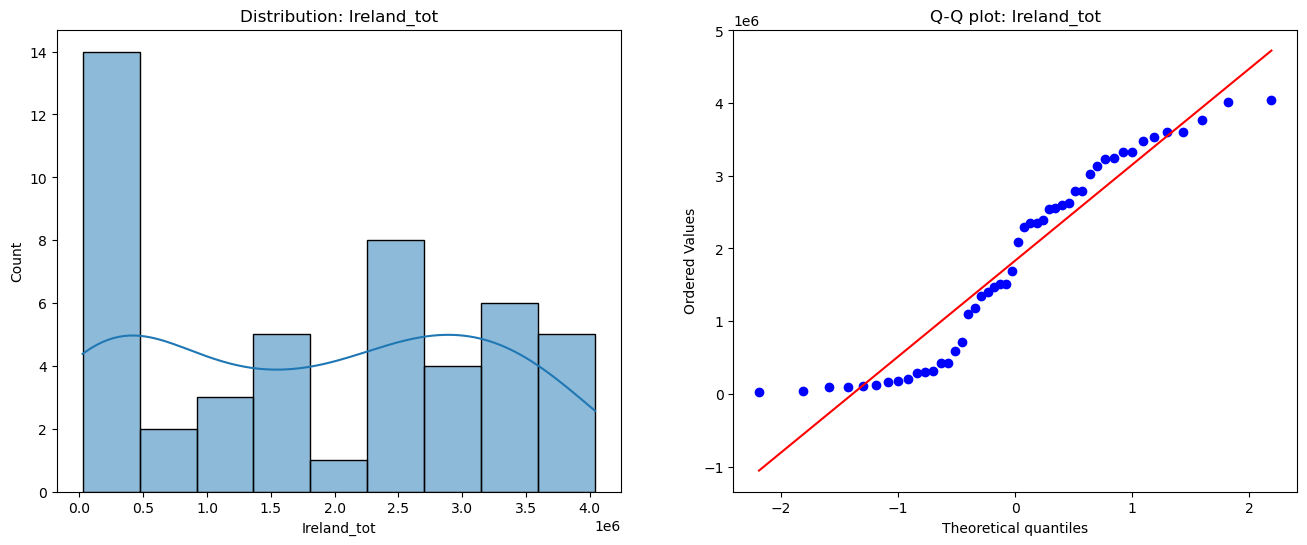

Statistics=0.907, p=0.001
Ireland_tot does not look Gaussian (reject null hypothesis)


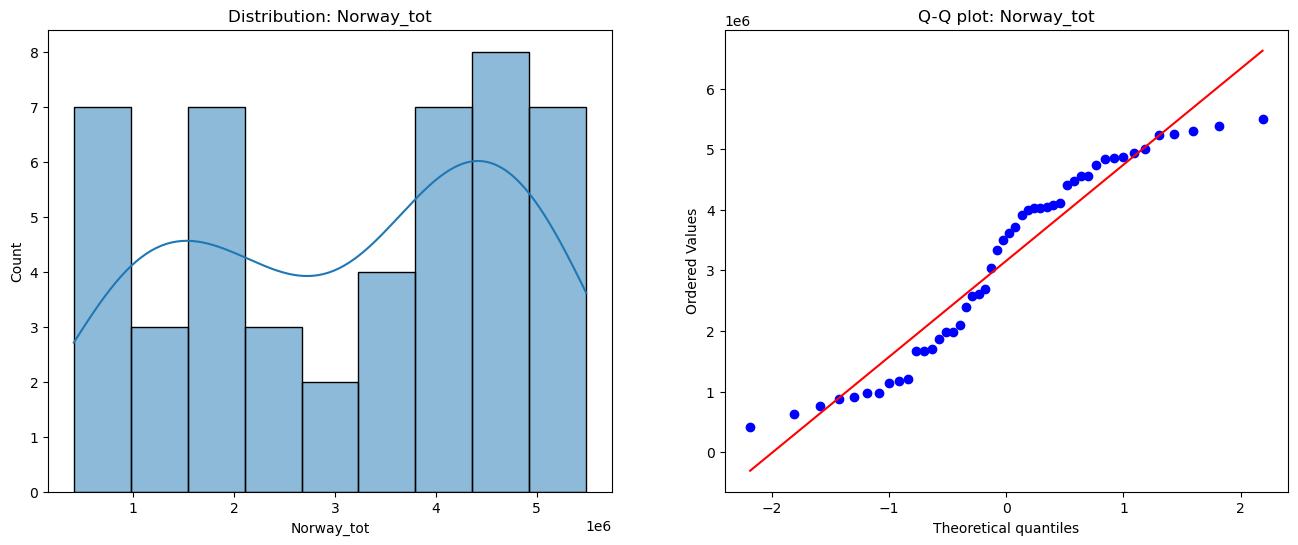

Statistics=0.920, p=0.003
Norway_tot does not look Gaussian (reject null hypothesis)


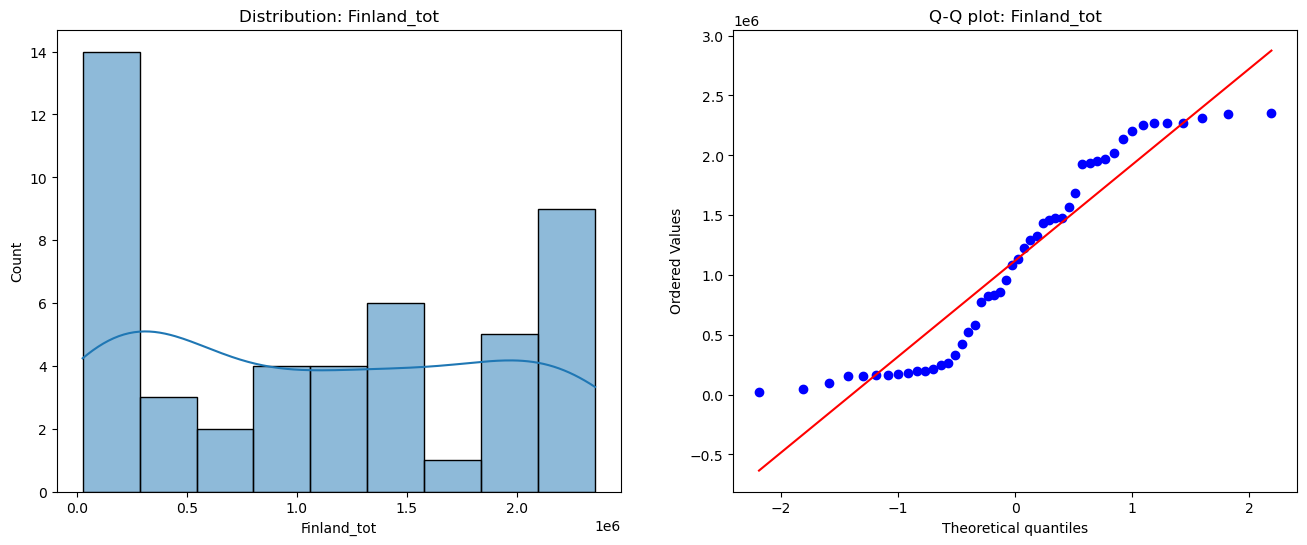

Statistics=0.891, p=0.000
Finland_tot does not look Gaussian (reject null hypothesis)


In [22]:
normality_check(total_nums,'Ireland_tot')
normality_check(total_nums,'Norway_tot')
normality_check(total_nums,'Finland_tot')

Since all three samples are not normally distributed, for this comparison I will utilise the Kruskal-Wallis non-parametric test.
The Kruskal–Wallis test (1952) is a nonparametric approach to the one-way ANOVA. The procedure is used to compare three or more groups on a dependent variable that is measured on at least an ordinal level.

In [23]:
# mann whitney U test:
stat, p = kruskal(total_nums['Ireland_tot'].values,
                   total_nums['Norway_tot'].values,
                   total_nums['Finland_tot'].values)

print('Statistical Test:', stat)
print('p-value:',p)

Statistical Test: 38.79073275862066
p-value: 3.7731094814235784e-09


when p-value < alpha, then we reject H0, and if p-value>alpha, then we accept it.

In this case, p-value < 0.05, therefore we reject H0

Interpretation: at a 5% significance level we have no evidence to indicate that the passenger numbers transiting through Irish, Norweigen and Finish airports is the same.

### 3.3.2 -  test 2: comparing passengers flying domestically in Norway and Ireland

Stating the hypothesis:

**H0**: There is no difference between the passengers flying domestically in Ireland and Norway

**H1**: The number of passengers flying domestically in Ireland and Norway is significantly different.


In [24]:
##merging values
domestic = ireland_domestic_passengers.merge(norway_domestic_passengers, on=['year','month'],how='left')

domestic = domestic.rename(columns = {'passengers_x':'ireland_domestic_passengers','passengers_y':'norway_domestic_passengers'})

domestic.head()

,year,month,ireland_domestic_passengers,norway_domestic_passengers
0,2009,1,109500.0,1894400
1,2009,2,116000.0,2009866
2,2009,3,127500.0,2374603
3,2009,4,114600.0,2200063
4,2009,5,116300.0,2329501


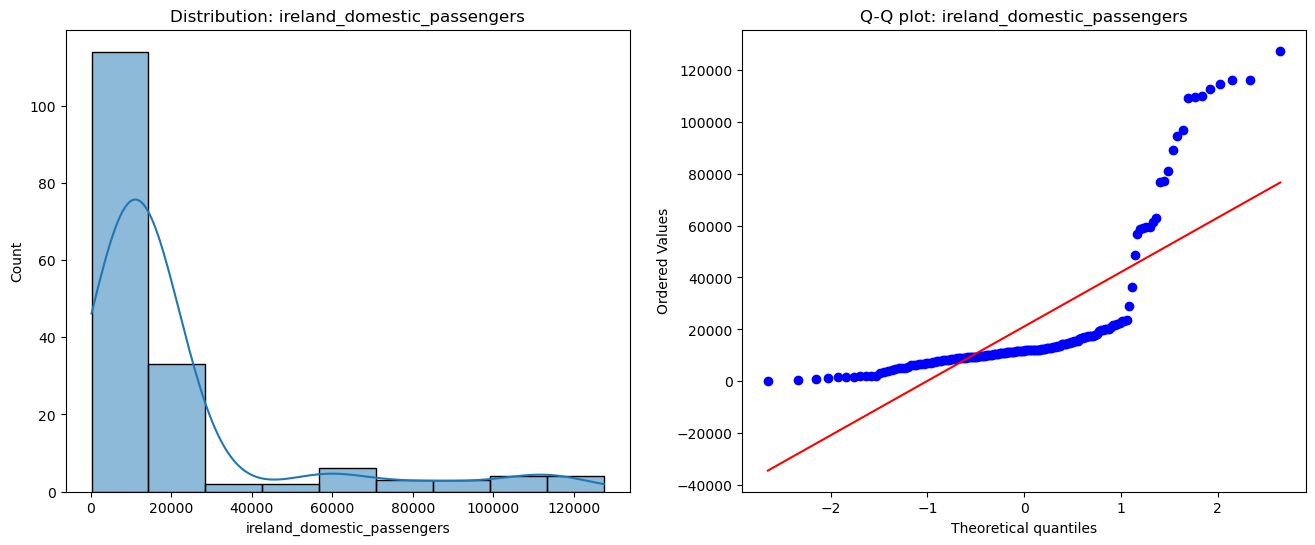

Statistics=0.586, p=0.000
ireland_domestic_passengers does not look Gaussian (reject null hypothesis)


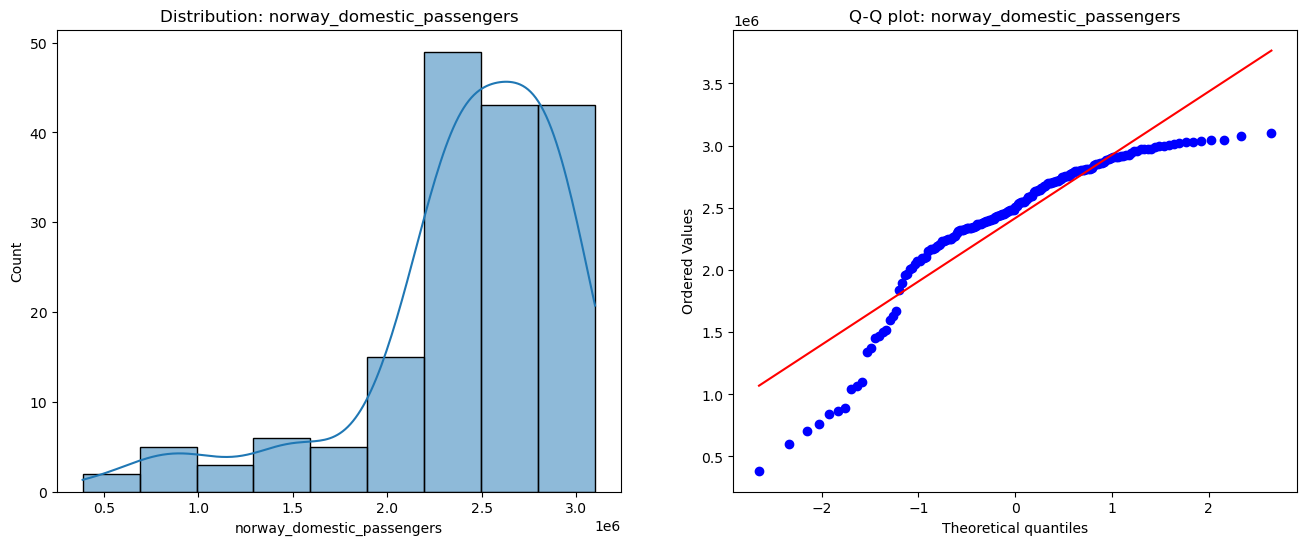

Statistics=0.850, p=0.000
norway_domestic_passengers does not look Gaussian (reject null hypothesis)


In [25]:
normality_check(domestic,'ireland_domestic_passengers')
normality_check(domestic,'norway_domestic_passengers')

- since the data is not normally distributed we will use a non-parametric test for this.
- I will use the mann whitney U test for this as we are only comparing two samples.

In [26]:
# mann whitney U test:
stat, p = mannwhitneyu(domestic['ireland_domestic_passengers'].values,
                       domestic['norway_domestic_passengers'].values)

print('Statistical Test:', stat)
print('p-value:',p)

Statistical Test: 0.0
p-value: 1.4577049389643454e-57


As p-value < 0.05, then we reject H0

Interpretation: at a 5% significance level, there is no evidence to say that the domestic passengers in Norway is the same as the domestic passengers in Ireland.

### 3.3.3 -  test 3: comparing international passengers flying to/from Norway and Ireland

Stating the hypothesis:

**H0**: There is no difference between the passengers flying Internationally out of/in to Ireland and Norway

**H1**: The number of passengers flying Internationally out of/in to Ireland and Norway is significantly different.


In [27]:
##merging values
international = ireland_international_passengers.merge(norway_international_passengers, on=['year','month'],how='left')

international = international.rename(columns = {'passengers_x':'ireland_international_passengers',
                                           'passengers_y':'norway_international_passengers'})

international.head()

,year,month,ireland_international_passengers,norway_international_passengers
0,2009,1,1764100.0,921069
1,2009,2,1757700.0,960605
2,2009,3,2070100.0,1099326
3,2009,4,2132800.0,1159282
4,2009,5,2296300.0,1262124


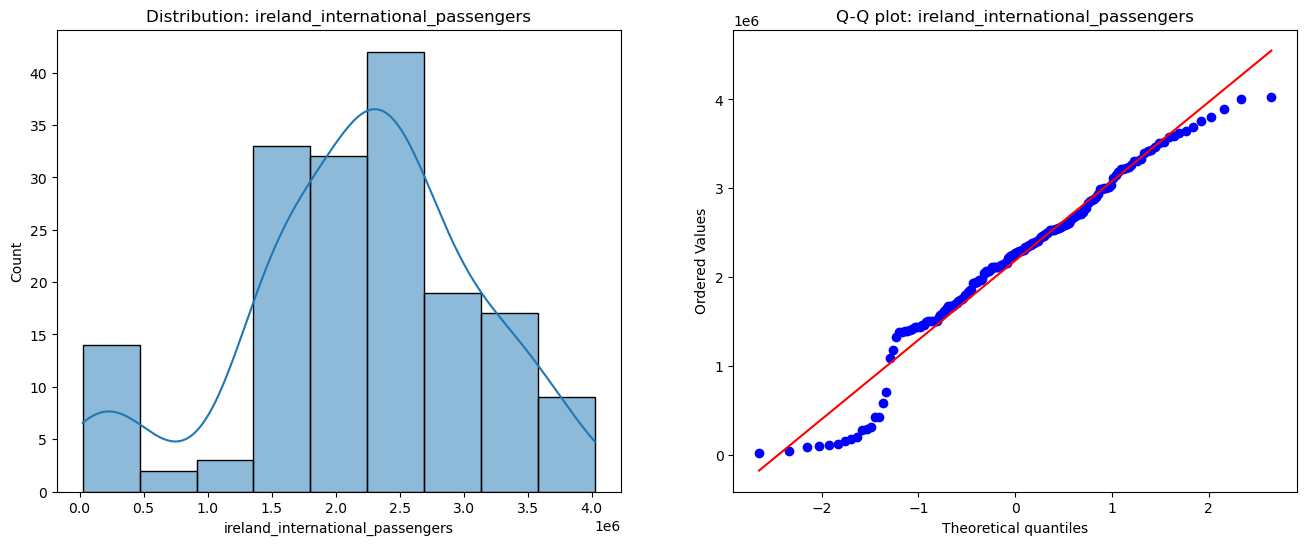

Statistics=0.966, p=0.000
ireland_international_passengers does not look Gaussian (reject null hypothesis)


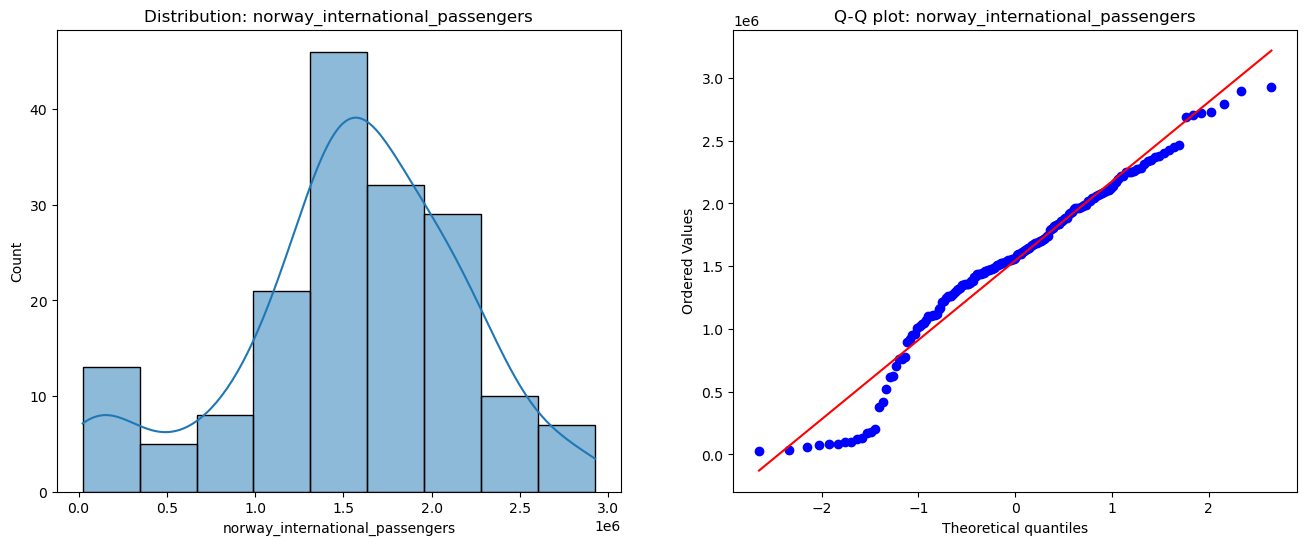

Statistics=0.960, p=0.000
norway_international_passengers does not look Gaussian (reject null hypothesis)


In [28]:
normality_check(international,'ireland_international_passengers')
normality_check(international,'norway_international_passengers')

- since the data is not normally distributed we will use a non-parametric test for this.
- I will use the mann whitney U test for this as we are only comparing two samples.

In [29]:
# mann whitney U test:
stat, p = mannwhitneyu(international['ireland_international_passengers'].values,
                       international['norway_international_passengers'].values)

print('Statistical Test:', stat)
print('p-value:',p)

Statistical Test: 21713.0
p-value: 8.668786200425556e-15


As p-value < 0.05, then we reject H0

Interpretation: at a 5% significance level, there is no evidence to say that passengers flying Internationally in to/out of Norway and Ireland is the same.

### 3.3.4 -  test 4: comparing international air freight in Norway and Ireland

Stating the hypothesis:

**H0**: There is no difference between tonnes of freight flying Internationally out of/in to Ireland and Norway

**H1**: The tonnes of freight flying Internationally out of/in to Ireland and Norway is significantly different.


In [30]:
international_freight = ireland_international_freight.merge(norway_international_freight, on=['year','month'],how='left')

international_freight = international_freight.rename(columns = {'freight_x':'ireland_international_freight',
                                           'freight_y':'norway_international_freight'})

international_freight.head()

,year,month,ireland_international_freight,norway_international_freight
0,2009,1,7200.0,3116
1,2009,2,6800.0,3647
2,2009,3,7400.0,3913
3,2009,4,6700.0,3343
4,2009,5,6900.0,3534


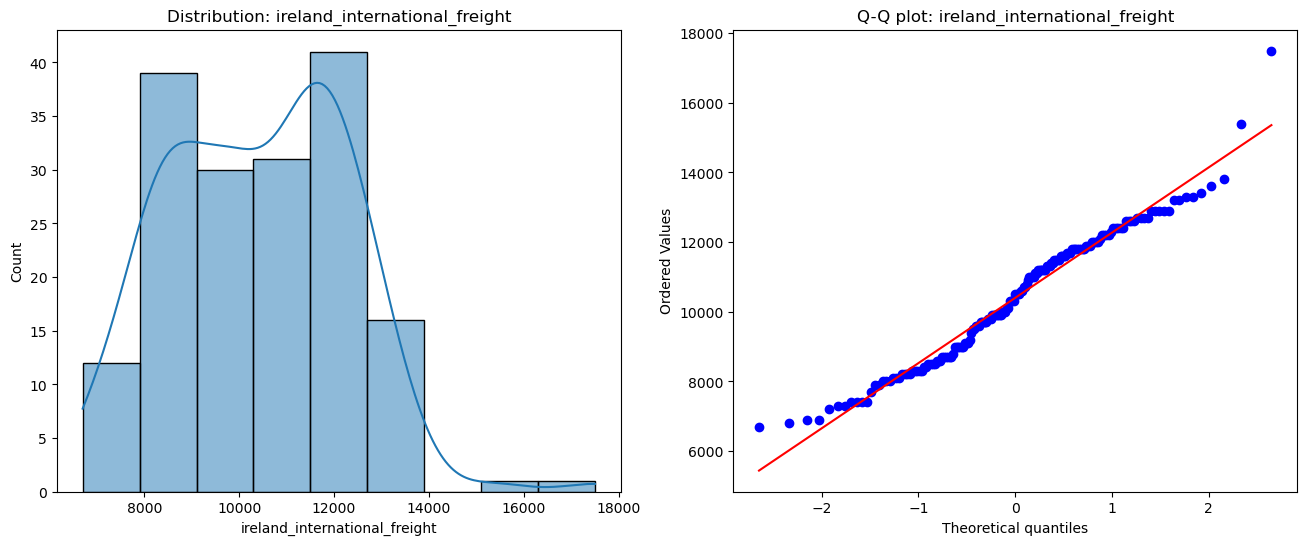

Statistics=0.973, p=0.002
ireland_international_freight does not look Gaussian (reject null hypothesis)


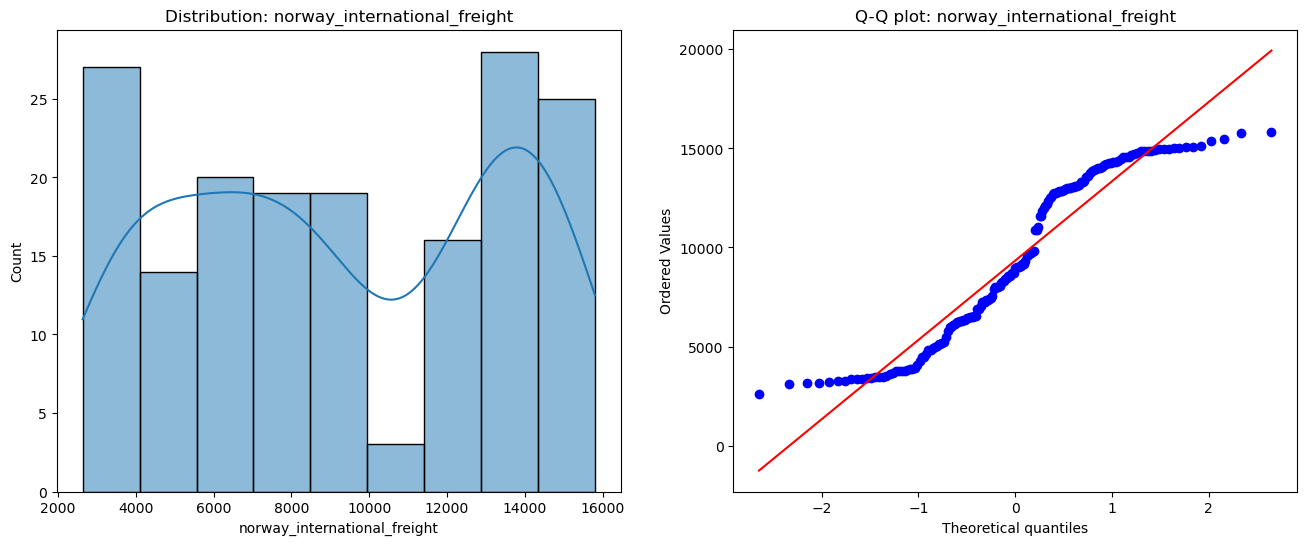

Statistics=0.913, p=0.000
norway_international_freight does not look Gaussian (reject null hypothesis)


In [31]:
normality_check(international_freight,'ireland_international_freight')
normality_check(international_freight,'norway_international_freight')

- since the data is not normally distributed we will use a non-parametric test for this.
- I will use the mann whitney U test for this as we are only comparing two samples.

In [32]:
# mann whitney U test:
stat, p = mannwhitneyu(international_freight['ireland_international_freight'].values,
                       international_freight['norway_international_freight'].values)

print('Statistical Test:', stat)
print('p-value:',p)

Statistical Test: 16499.0
p-value: 0.03994872687216135


Even though the p-value for this comparison is much larger than the other tests, it is still less than alpha (0.05), so we must still reject the null hypothesis.

Interpretation: at a 5% significance level, there is no evidence to say that the tonnes of freight flying Internationally in to/out of Norway and Ireland is the same.

### 3.3.5 - test 5: comparing domestic air freight in Norway and Ireland

Stating the hypothesis:

**H0**: There is no difference between tonnes of freight flying domestically in Ireland and Norway

**H1**: The tonnes of freight flying domestically in Ireland and Norway is significantly different.

In [33]:
domestic_freight = ireland_domestic_freight.merge(norway_domestic_freight, on=['year','month'],how='left')

domestic_freight = domestic_freight.rename(columns = {'freight_x':'ireland_domestic_freight',
                                           'freight_y':'norway_domestic_freight'})
domestic_freight.tail()

,year,month,ireland_domestic_freight,norway_domestic_freight
166,2022,11,700.0,1747
167,2022,12,500.0,1500
168,2023,1,600.0,1675
169,2023,2,500.0,1596
170,2023,3,700.0,2031


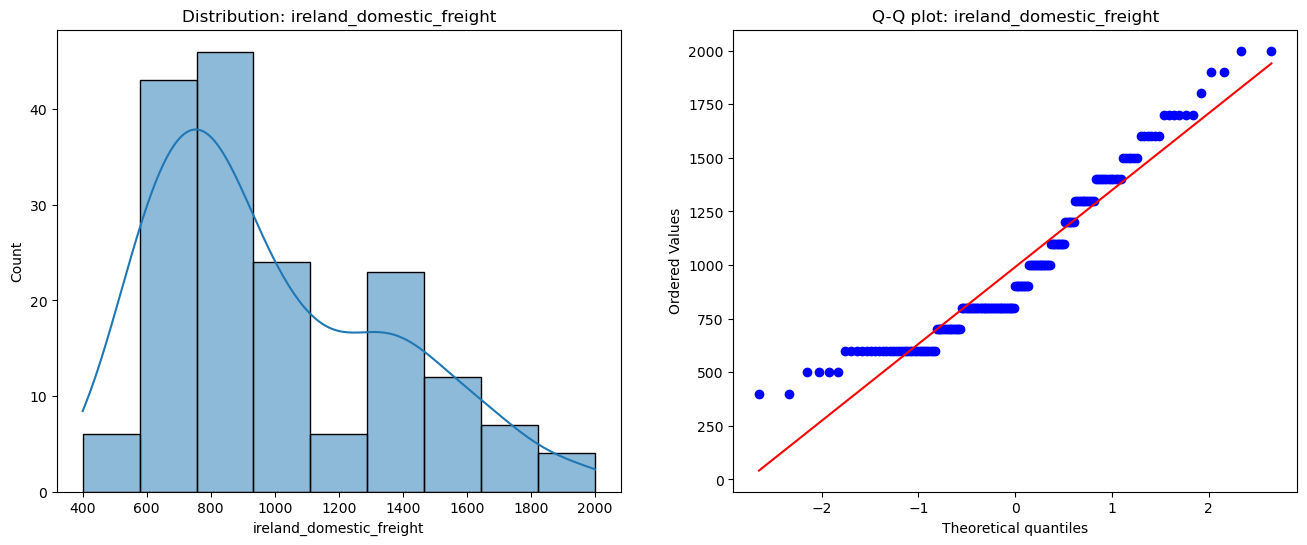

Statistics=0.918, p=0.000
ireland_domestic_freight does not look Gaussian (reject null hypothesis)


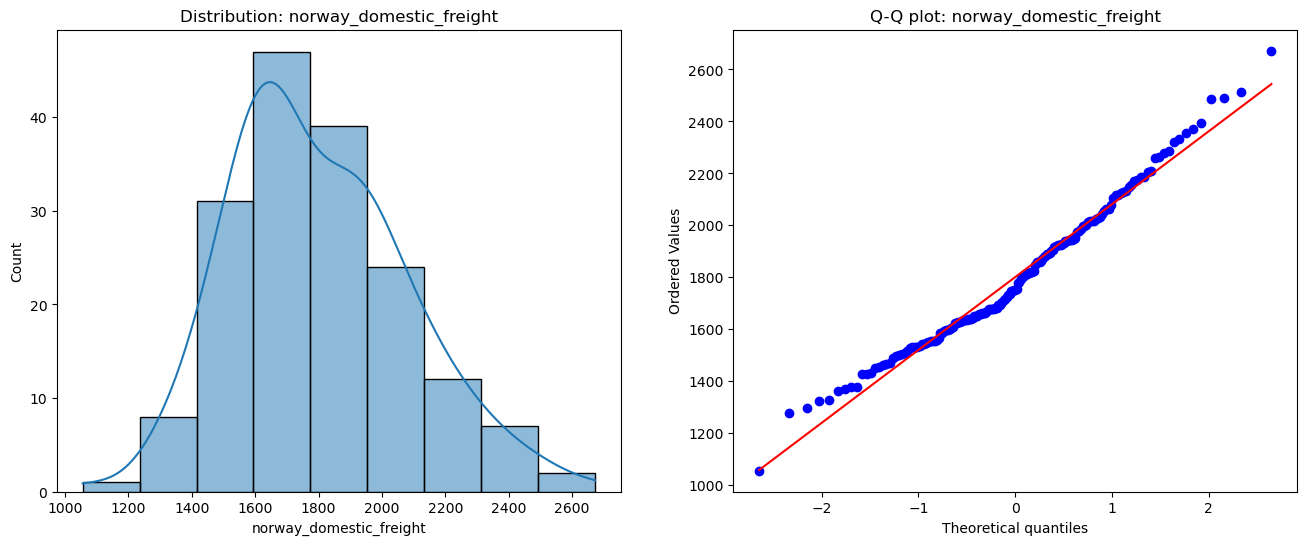

Statistics=0.982, p=0.023
norway_domestic_freight does not look Gaussian (reject null hypothesis)


In [34]:
normality_check(domestic_freight,'ireland_domestic_freight')
normality_check(domestic_freight,'norway_domestic_freight')

- since the data is not normally distributed we will use a non-parametric test for this.
- I will use the mann whitney U test for this as we are only comparing two samples.

In [35]:
# mann whitney U test:
stat, p = mannwhitneyu(domestic_freight['ireland_domestic_freight'].values,
                       domestic_freight['norway_domestic_freight'].values)

print('Statistical Test:', stat)
print('p-value:',p)

Statistical Test: 1557.0
p-value: 2.0817286502890214e-46


As p-value < 0.05, then we reject H0

Interpretation: at a 5% significance level, there is no evidence to say that domestic air freight in Norway and Ireland is the same.